**Evolution of the confguration space of open-source software projects**

- statistics:
    - growth of config files
    - change frequency of config files
    - distribution of config-related and non-config-related commit
    - distribution of contributors that perform config changes
    - total number of options over time
    - total number of links over time

In [2]:
import json

data_file = "../data/analyzed_projects/leaf.json"

with open(data_file, "r", encoding="utf-8") as src:
    data = json.load(src)

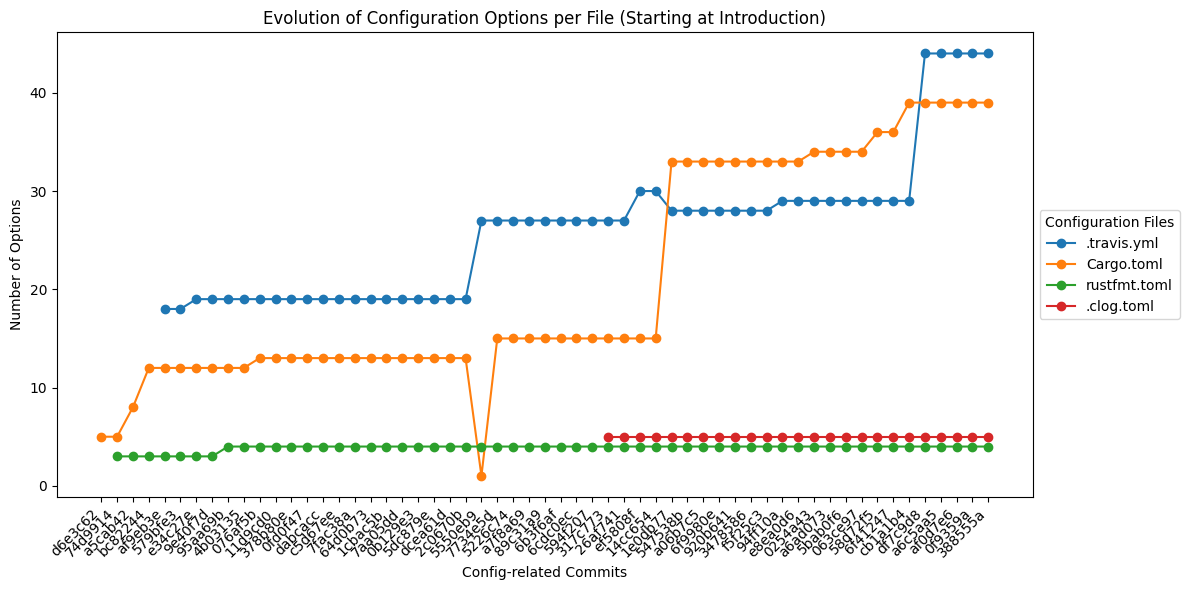

In [3]:
import matplotlib.pyplot as plt
from typing import List

def plot_config_file_evolution(data: List):
    # Extract data for plotting
    files = set()
    file_data = {}

    commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    for commit in commit_data:
        commit_hash = commit["commit_hash"]
        for config_file in commit["network_data"]["config_files_data"]:
            file_path = config_file["file_path"]
            options = config_file["options"]
            files.add(file_path)
            if file_path not in file_data:
                file_data[file_path] = []
            file_data[file_path].append((commit_hash, options))

    # Prepare data for plotting
    x_ticks = [commit["commit_hash"] for commit in commit_data]

    # Adjust the plotting logic to start the line at the introduction commit
    file_lines = {file: [None] * len(x_ticks) for file in files}

    for file, changes in file_data.items():
        for commit_hash, options in changes:
            index = x_ticks.index(commit_hash)
            file_lines[file][index] = options

    # Replace None with previous values for continuity
    for file, options in file_lines.items():
        last_value = None
        for i in range(len(options)):
            if options[i] is None:
                options[i] = last_value
            else:
                last_value = options[i]

    shortened_x_ticks = [commit[:7] for commit in x_ticks]

    # Re-plot with shortened commit hashes
    plt.figure(figsize=(12, 6))
    for file, options in file_lines.items():
        plt.plot(shortened_x_ticks, options, marker="o", label=file)

    plt.xlabel("Config-related Commits")
    plt.ylabel("Number of Options")
    plt.title("Evolution of Configuration Options per File (Starting at Introduction)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Configuration Files", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"../data/figures/{data['project_name']}_options_per_file.png")


plot_config_file_evolution(data=data)

**Evolution of the configuration options**

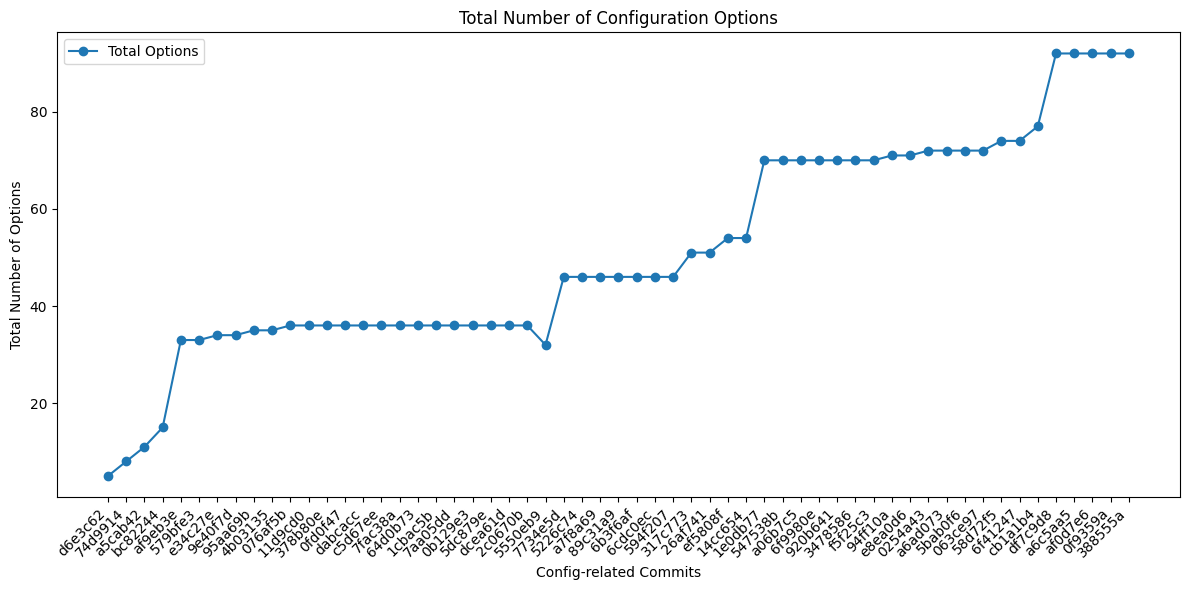

In [4]:
import matplotlib.pyplot as plt


def plot_num_options_evolution(data: List):
    # Extract data for plotting
    files = set()
    file_data = {}

    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    for commit in config_commit_data:
        commit_hash = commit["commit_hash"]
        for config_file in commit["network_data"]["config_files_data"]:
            file_path = config_file["file_path"]
            options = config_file["options"]
            files.add(file_path)
            if file_path not in file_data:
                file_data[file_path] = []
            file_data[file_path].append((commit_hash, options))

    # Prepare data for plotting
    x_ticks = [commit["commit_hash"] for commit in config_commit_data]

    shortened_x_ticks = [commit[:7] for commit in x_ticks]

    # Adjust the plotting logic to start the line at the introduction commit
    file_lines = {file: [None] * len(x_ticks) for file in files}

    for file, changes in file_data.items():
        for commit_hash, options in changes:
            index = x_ticks.index(commit_hash)
            file_lines[file][index] = options

    # Calculate the total number of options across all configuration files per commit
    total_options_per_commit = [0] * len(x_ticks)

    for file, options in file_lines.items():
        for i, option_count in enumerate(options):
            if option_count is not None:
                total_options_per_commit[i] += option_count

    # Plot the total number of options over time
    plt.figure(figsize=(12, 6))
    plt.plot(shortened_x_ticks, total_options_per_commit, marker="o", label="Total Options")

    plt.xlabel("Config-related Commits")
    plt.ylabel("Total Number of Options")
    plt.title("Total Number of Configuration Options")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"../data/figures/{data['project_name']}_total_options.png")

plot_num_options_evolution(data=data)

**Evolution of Links**

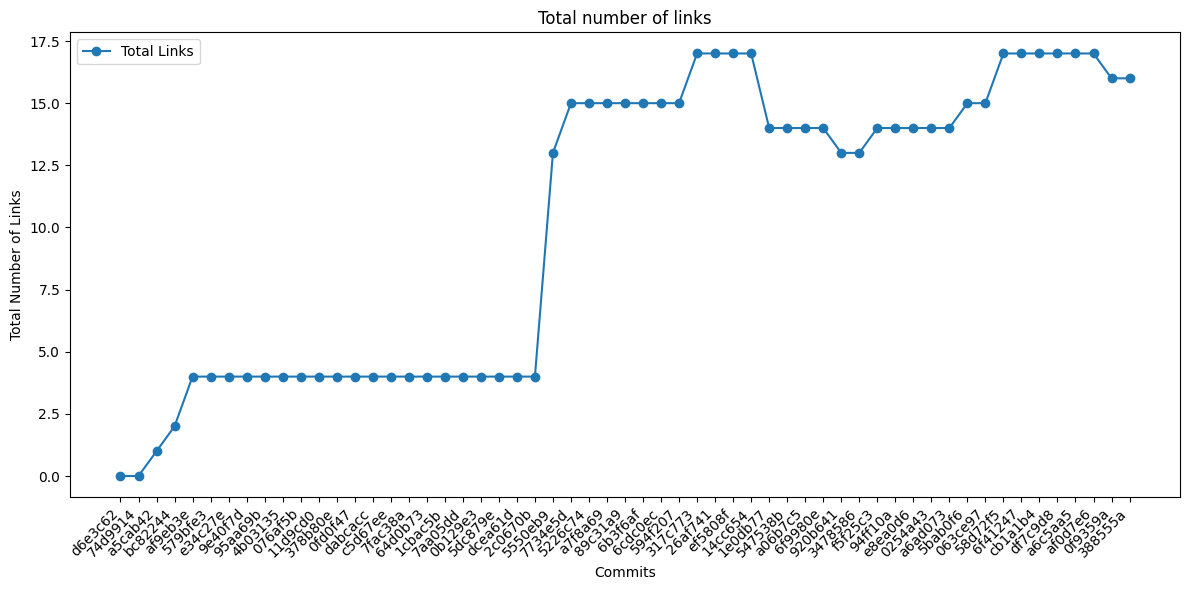

In [5]:
def plot_num_links_evolution(data: List):

    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    # Extract the total number of links per commit
    total_links_per_commit = [commit["network_data"]["links"] for commit in config_commit_data]

    # Shorten commit hashes for x-axis
    shortened_x_ticks = [commit["commit_hash"][:7] for commit in config_commit_data]

    # Plot the total number of links over time
    plt.figure(figsize=(12, 6))
    plt.plot(shortened_x_ticks, total_links_per_commit, marker="o", label="Total Links")

    plt.xlabel("Commits")
    plt.ylabel("Total Number of Links")
    plt.title("Total number of links")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"../data/figures/{data['project_name']}total_links.png")

plot_num_links_evolution(data=data)

**Distribution of config-related and non-config-related commits**

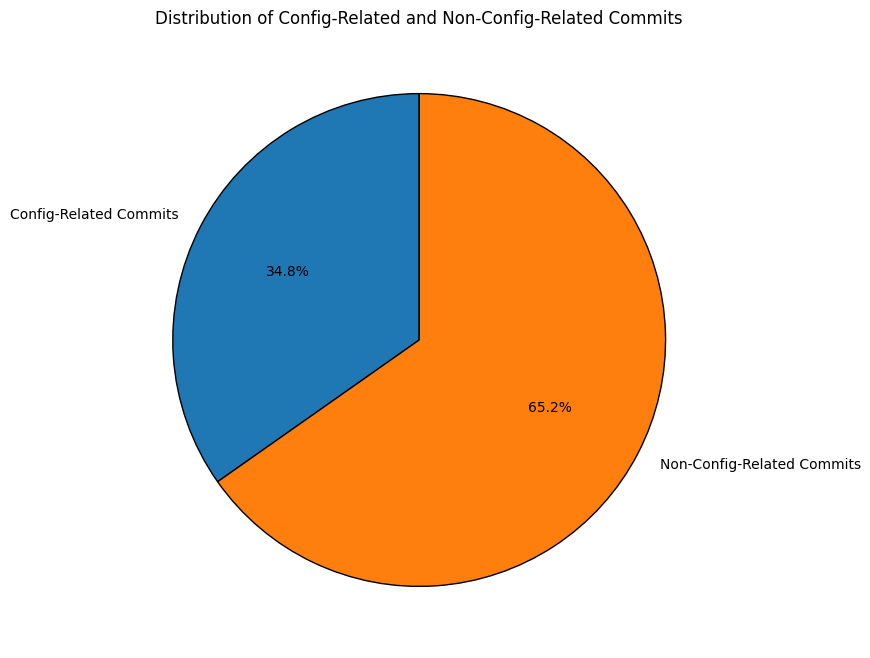

In [6]:
import matplotlib.pyplot as plt

# TODO: as we only store config related commit, we need to calculate: # total commits/ # config related commits

def plot_config_commits_distribution(data: List):
    
    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]
    commit_data = [commit for commit in data["config_commit_data"] if not commit["is_config_related"]]

    assert len(config_commit_data) + len(commit_data) == data["len_commits"]

    # Data for the pie chart
    labels = ['Config-Related Commits', 'Non-Config-Related Commits']
    sizes = [len(config_commit_data), len(commit_data)]

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
    plt.title("Distribution of Config-Related and Non-Config-Related Commits")
    #plt.show()
    plt.savefig(f"../data/figures/{data['project_name']}_commit_distribution.png")


plot_config_commits_distribution(data=data)

**Frequency how often a specific config file has changed**

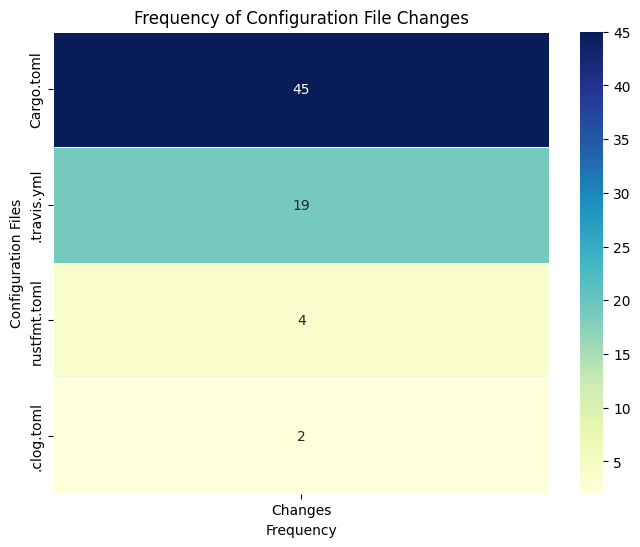

In [22]:
import seaborn as sns
import pandas as pd


def plot_config_file_changes_frequency(data: List):
    # Count how often each configuration file has changed
    config_commit_data = [commit for commit in data["config_commit_data"] if commit["is_config_related"]]

    file_change_counts = {}

    for commit in config_commit_data:
        for config_file in commit["network_data"]["config_files_data"]:
            file_path = config_file["file_path"]
            insertions = config_file.get("insertions", 0)
            deletions = config_file.get("deletions", 0)
            if insertions > 0 or deletions > 0:
                file_change_counts[file_path] = file_change_counts.get(file_path, 0) + 1

    # Convert data to a DataFrame for heatmap plotting
    file_change_df = pd.DataFrame(list(file_change_counts.items()), columns=["File", "Changes"])
    file_change_df = file_change_df.sort_values(by="Changes", ascending=False)

    # Create heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(file_change_df.set_index("File"), annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)

    plt.title("Frequency of Configuration File Changes")
    plt.xlabel("Frequency")
    plt.ylabel("Configuration Files")
    #plt.show()
    plt.savefig(f"../data/figures/{data['project_name']}_change_frequency.png")

plot_config_file_changes_frequency(data=data)